In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=af4f589aac912846fb50570d3e28bed48c895caf613e0a3bfbe4599d90704114
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 1. Chuẩn bị dữ liệu

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.initializers import GlorotNormal
import tensorflow as tf
from keras.callbacks import History
import matplotlib.pyplot as plt

In [6]:
# Load the dataset
dataset = pd.read_csv('/content/drive/MyDrive/ML/dataset_all.csv')
dataset

,Unnamed: 0,domain,class
0,0,google.com,legit
1,1,facebook.com,legit
2,2,youtube.com,legit
3,3,baidu.com,legit
4,4,yahoo.com,legit
...,...,...,...
1799995,1799995,yacoouemkmmeaqiu.org,ramdo
1799996,1799996,yaucyikacowiogem.org,ramdo
1799997,1799997,iumgkaoasgoyiccy.org,ramdo
1799998,1799998,aemosuaokkwmqqmq.org,ramdo


In [15]:
sampled_df = dataset.groupby('class').apply(lambda x: x.sample(3)).reset_index(drop=True)
sampled_df

,Unnamed: 0,domain,class
0,1068769,tufnm.cc,conficker
1,1076558,lbtgyhdhk.info,conficker
2,1038373,sjkvhvg.com,conficker
3,1197382,hfrckpmlpqdj.co.uk,cryptolocker
4,1186476,ovihbhbufnbxkw.co.uk,cryptolocker
5,1176896,eunclspodlrdmv.net,cryptolocker
6,906805,ycat.co.jp,legit
7,624950,sfogliashopping.it,legit
8,67206,secondshaadi.com,legit
9,1658897,judgestableactcommunicate.com,matsnu


# 2. Normalize dữ liệu

In [ ]:
# Mã hóa nhãn lớp
label_encoder = LabelEncoder()
# Gán 0 cho nhãn 'legit' và 1 cho các lớp DGA khác
dataset['class'] = dataset['class'].apply(lambda x: 0 if x == 'legit' else 1)
encoded_class = dataset['class'].values

# Mã hóa tên miền
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(dataset['domain'])
encoded_domain = tokenizer.texts_to_sequences(dataset['domain'])

# Lấp đầy các chuỗi để đảm bảo độ dài đồng nhất
max_sequence_length = max([len(seq) for seq in encoded_domain])
padded_domain = pad_sequences(encoded_domain, maxlen=max_sequence_length)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(padded_domain, encoded_class, test_size=0.2, random_state=42)

# Xác định kích thước từ vựng
vocab_size = len(tokenizer.word_index) + 1  # Thêm 1 vì chỉ số 0 được dành riêng

# 3. Xây dựng và huấn luyện model

In [ ]:
# Chọn chiều nhúng
embedding_dim = 64

from keras.initializers import GlorotNormal

# Định nghĩa kiến trúc mô hình với bộ khởi tạo GlorotNormal được gieo hạt
model = Sequential()

# Embedding: Tạo một lớp nhúng, chuyển đổi các số nguyên đại diện cho các từ thành các vector dày đặc.
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Thêm lớp LSTM dưới dạng đối xứng
# Bidirectional LSTM: Một lớp LSTM đối xứng để mô hình học từ cả hai phía của chuỗi.
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Thêm tự chú ý dãn dấu trình tự
# SeqSelfAttention: Lớp tự chú ý dãn dấu trình tự để mô hình tập trung vào các phần quan trọng của dữ liệu đầu vào.
model.add(SeqSelfAttention(attention_activation='sigmoid'))

# Áp dụng dropout để tránh overfitting
# Dropout: Lớp dropout để tránh overfitting bằng cách loại bỏ một phần của các nơ-ron trong quá trình huấn luyện.
model.add(Dropout(0.5))

# Thêm lớp LSTM đối xứng khác
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

# Thêm chú ý trọng số trình tự
model.add(SeqWeightedAttention())

# Áp dụng dropout để tránh overfitting
model.add(Dropout(0.5))

# Thêm lớp kích hoạt ReLU
model.add(Dense(units=64, activation='relu'))

# Áp dụng dropout để tránh overfitting
model.add(Dropout(0.5))

# Thêm lớp kích hoạt sigmoid cho việc phân loại nhị phân
model.add(Dense(units=1, activation='sigmoid'))

# Biên dịch mô hình với các tham số chính xác
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Tóm tắt mô hình
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 73, 64)            2560      
                                                                 
 bidirectional (Bidirection  (None, 73, 128)           66048     
 al)                                                             
                                                                 
 seq_self_attention (SeqSel  (None, 73, 128)           8257      
 fAttention)                                                     
                                                                 
 dropout (Dropout)           (None, 73, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 73, 128)           98816     
 onal)                                                           
                                                        

In [ ]:
# Tạo callback History và EarlyStopping
history = History()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
45000/45000 [==============================] - 934s 20ms/step - loss: 0.0861 - accuracy: 0.9690 - val_loss: 0.0510 - val_accuracy: 0.9821
Epoch 2/10
45000/45000 [==============================] - 899s 20ms/step - loss: 0.0458 - accuracy: 0.9845 - val_loss: 0.0423 - val_accuracy: 0.9862
Epoch 3/10
45000/45000 [==============================] - 893s 20ms/step - loss: 0.0370 - accuracy: 0.9875 - val_loss: 0.0430 - val_accuracy: 0.9854
Epoch 4/10
45000/45000 [==============================] - 903s 20ms/step - loss: 0.0324 - accuracy: 0.9890 - val_loss: 0.0332 - val_accuracy: 0.9885
Epoch 5/10
45000/45000 [==============================] - 898s 20ms/step - loss: 0.0302 - accuracy: 0.9897 - val_loss: 0.0327 - val_accuracy: 0.9888
Epoch 6/10
45000/45000 [==============================] - 890s 20ms/step - loss: 0.0324 - accuracy: 0.9888 - val_loss: 0.0358 - val_accuracy: 0.9879
Epoch 7/10
45000/45000 [==============================] - 888s 20ms/step - loss: 0.0569 - accuracy: 0.9806

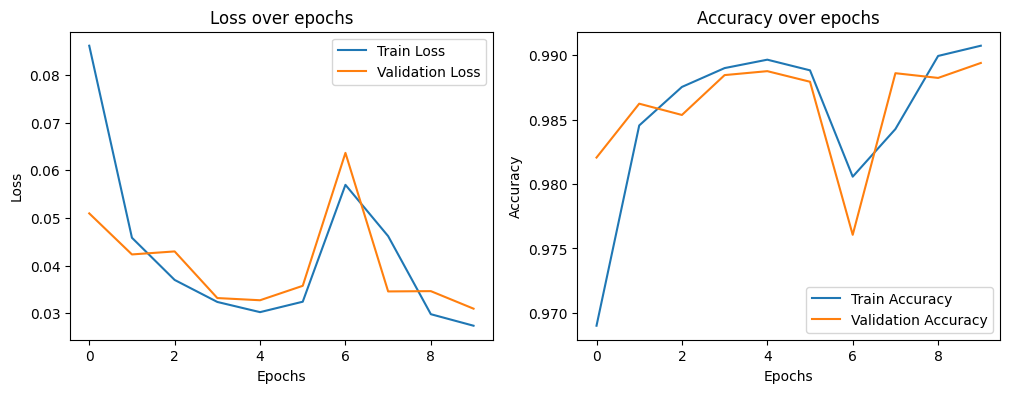

In [ ]:
# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 4))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

11250/11250 [==============================] - 89s 8ms/step - loss: 0.0310 - accuracy: 0.9894
Test Loss: 0.03096206672489643
Test Accuracy: 0.9894000291824341


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Tính toán Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

11250/11250 [==============================] - 84s 7ms/step
Accuracy: 0.9894
Precision: 0.9874665117934691
Recall: 0.9886890135244133
F1-score: 0.9880773845230953
